In [73]:
import pandas as pd
from datetime import datetime

In [89]:
import matplotlib.pyplot as plt

# Load dataset

In [7]:
df = pd.read_csv('Banking_Book_IRRBB.csv')

# Convert date columns to datetime

In [13]:
df['maturity_date'] = pd.to_datetime(df['maturity_date'])
df['origination_date'] = pd.to_datetime(df['origination_date'])

# Add derived fields

In [19]:
df['tenor_years'] = (df['maturity_date'] - datetime.today()).dt.days/365
df['adjusted_tenor'] = df['tenor_years'] * (1-df['behavioral_adjustment']) #Behavioral Maturity Adjustment

# Define shock as % value

In [23]:
shocks = {
    'Base': 0.00,
    'Parallel_Up': 0.02,
    'Parallel_Down': -0.02
}

# Assume flat base curve as 3% for simplicity

In [27]:
base_rate = 0.03

# Present value and EVE calculation

In [47]:
def calculate_present_value(row, rate_shift):
    rate = base_rate + rate_shift
    n = max(1, round(row['adjusted_tenor'] * 1/1)) #Assume annual cash flows for simplification
    r = rate
    pv = 0
    for t in range(1, n+1):
        pv += row['notional_amount'] * row['interest_rate']/100/(1+r) ** t
    pv += row['notional_amount']/(1 + r) ** n #Principal repayment
    return pv

# Compute EVE per scenario

In [51]:
for label, shift in shocks.items():
    df[f'EVE_{label}'] = df.apply(lambda row: calculate_present_value(row, shift), axis=1)

# ΔEVE = EVE_Shock - EVE_Base

In [55]:
df['Delta_EVE_Up'] = df['EVE_Parallel_Up'] - df['EVE_Base']
df['Delta_EVE_Down'] = df['EVE_Parallel_Down'] - df['EVE_Base']

# Compute NII under shocks

In [59]:
def calculate_nii(row, rate_shift):
    if row['interest_rate_type'] == 'Floating':
        effective_rate = row['interest_rate'] / 100 + rate_shift
    else:
        effective_rate = row['interest_rate'] / 100
    return row['notional_amount'] * effective_rate

# Apply across scenarios

In [65]:
for label, shift in shocks.items():
    df[f'NII_{label}'] = df.apply(lambda row: calculate_nii(row, shift), axis=1)

df['Delta_NII_Up'] = df['NII_Parallel_Up'] - df['NII_Base']
df['Delta_NII_Down'] = df['NII_Parallel_Down'] - df['NII_Base']

# Portfolio level aggregation

In [ ]:
summary = df[[
    'EVE_Base', 'EVE_Parallel_Up', 'EVE_Parallel_Down',
    'Delta_EVE_Up', 'Delta_EVE_Down',
    'NII_Base', 'NII_Parallel_Up', 'NII_Parallel_Down',
    'Delta_NII_Up', 'Delta_NII_Down'
]].sum()

print("🔍 IRRBB Summary Impact:\n", summary.round(2))

# Portfolio-level ΔEVE and ΔNII across scenarios

In [83]:
delta_eve = {
    'Parallel_Up':df['Delta_EVE_Up'].sum(),
    'Parallel_Down':df['Delta_EVE_Down'].sum()
}

delta_nii = {
    'Parallel_Up':df['Delta_NII_Up'].sum(),
    'Parallel_Down':df['Delta_NII_Down'].sum()
}

# Plot

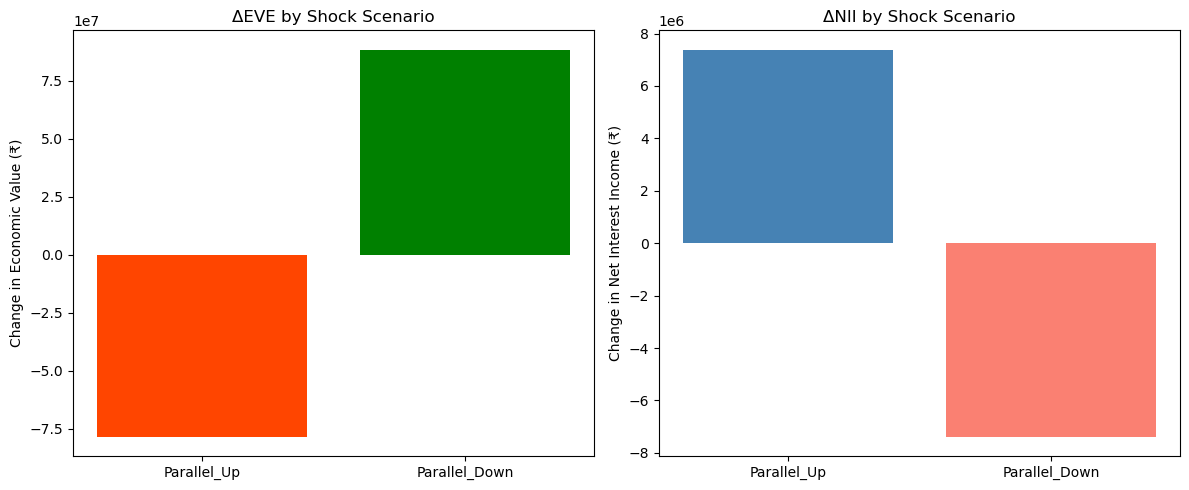

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(delta_eve.keys(), delta_eve.values(), color=['orangered', 'green'])
ax[0].set_title('ΔEVE by Shock Scenario')
ax[0].set_ylabel('Change in Economic Value (₹)')

ax[1].bar(delta_nii.keys(), delta_nii.values(), color=['steelblue', 'salmon'])
ax[1].set_title('ΔNII by Shock Scenario')
ax[1].set_ylabel('Change in Net Interest Income (₹)')

plt.tight_layout()
plt.show()

# Add Steepener and Flattener Scenarios

In [107]:
def get_curve_shock(adjusted_tenor, scenario):
    if scenario == 'Steepener':
        return -0.0025 + (adjusted_tenor / 10) * 0.01  # linear steepening
    elif scenario == 'Flattener':
        return 0.0075 - (adjusted_tenor / 10) * 0.01
    else:
        return 0

In [134]:
for scenario in ['Steepener', 'Flattener']:
    df[f'Shock_{scenario}'] = df['adjusted_tenor'].apply(lambda t: get_curve_shock(t, scenario))
    df[f'EVE_{scenario}'] = df.apply(
        lambda row: calculate_present_value(row, row[f'Shock_{scenario}']), axis=1
    )
    df[f'Delta_EVE_{scenario}'] = df[f'EVE_{scenario}'] - df['EVE_Base']
    df[f'NII_{scenario}'] = df.apply(
        lambda row: calculate_present_value(row, row[f'Shock_{scenario}']), axis=1
    )
    df[f'Delta_NII_{scenario}'] = df[f'NII_{scenario}'] - df['EVE_Base']

# Callable/Prepayable Duration Adjustment

In [112]:
def adjust_duration_for_option(row):
    base_adj = row['adjusted_tenor']
    if row['embedded_option'] == 'Callable':
        return base_adj * 0.85
    elif row['embedded_option'] == 'Prepayable':
        return base_adj * 0.7
    else:
        return base_adj

In [118]:
df['option_adjusted_tenor'] = df.apply(adjust_duration_for_option, axis=1)

# Aggregate ΔEVE for all scenarios

In [136]:
delta_eve = {
    'Parallel Up': df['Delta_EVE_Up'].sum(),
    'Parallel Down': df['Delta_EVE_Down'].sum(),
    'Steepener': df['Delta_EVE_Steepener'].sum(),
    'Flattener': df['Delta_EVE_Flattener'].sum()
}

delta_nii = {
    'Parallel Up': df['Delta_NII_Up'].sum(),
    'Parallel Down': df['Delta_NII_Down'].sum(),
    'Steepener': df['NII_Steepener'].sum() - df['NII_Base'].sum(),
    'Flattener': df['NII_Flattener'].sum() - df['NII_Base'].sum()
}

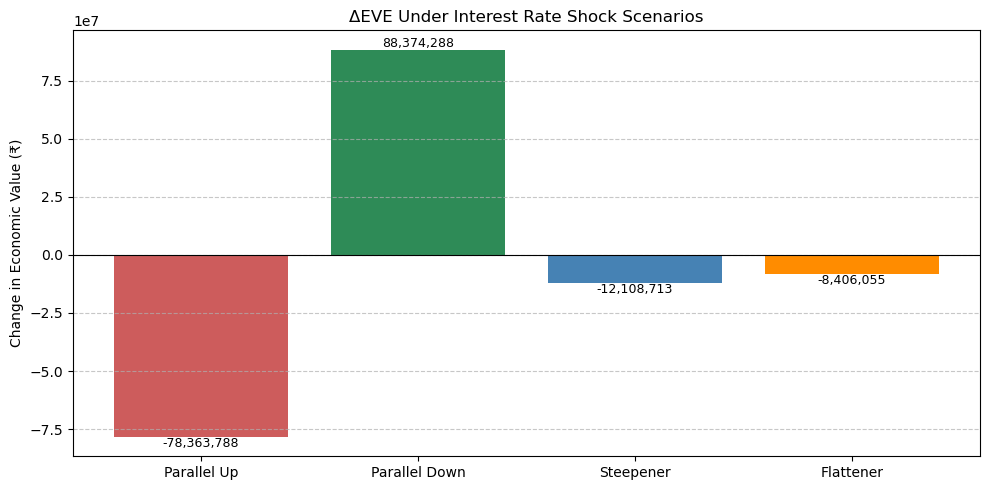

In [127]:
# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(delta_eve.keys(), delta_eve.values(),
               color=['indianred', 'seagreen', 'steelblue', 'darkorange'])

plt.title('ΔEVE Under Interest Rate Shock Scenarios')
plt.ylabel('Change in Economic Value (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)

# Add values on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval,
             f'{yval:,.0f}', ha='center', va='bottom' if yval > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# Plotting aggregate ΔNII for all four scenarios

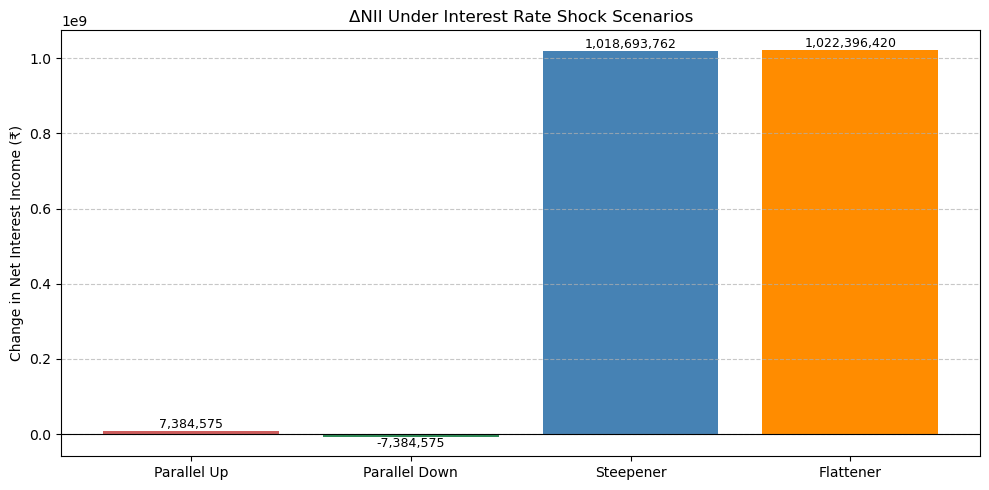

In [139]:
plt.figure(figsize=(10, 5))
bars = plt.bar(delta_nii.keys(), delta_nii.values(),
               color=['indianred', 'seagreen', 'steelblue', 'darkorange'])

plt.title('ΔNII Under Interest Rate Shock Scenarios')
plt.ylabel('Change in Net Interest Income (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f'{yval:,.0f}', ha='center', va='bottom' if yval > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()